# Load Data & Inspect

In [95]:
import pandas as pd
%matplotlib inline

In [96]:
acc_transactions = pd.read_csv('tj_02_account_transaction.csv')
card_transactions = pd.read_csv('tj_02_creditcard_transaction.csv', dtype={'card_no': object})
# Specify dtype because pandas convert string to float, and many digits are gone
acc_card = pd.read_csv('tj_02_acc_x_card.csv', dtype={'card_no': object})

testdata = pd.read_csv('tj_02_test.csv', header=None)
traindata = pd.read_csv('tj_02_training.csv', header=None)

In [97]:
traindata.columns = ['account_no', 'is_merchant']
testdata.columns = ['account_no']

In [98]:
acc_transactions['account_no'].astype(str).describe()

count        2012569
unique         16560
top       3450001101
freq           13447
Name: account_no, dtype: object

In [99]:
acc_card['account_no'].astype(str).describe()

count          11652
unique         11652
top       3450016089
freq               1
Name: account_no, dtype: object

In [100]:
acc_card['card_no'].astype(str).describe()

count     11652
unique     7368
top         nan
freq       4059
Name: card_no, dtype: object

In [101]:
acc_transactions.head()

,account_no,from_to_account_no,txn_amount,txn_dt,txn_hour,txn_type
0,3450045224,0,50,2016-04-03,17,DR
1,3450034734,0,10000,2016-10-07,13,DR
2,3450019126,3450594449,800,2016-10-03,18,CR
3,3450028971,3450596508,8650,2016-10-03,21,DR
4,3450000833,0,10000,2016-06-22,22,DR


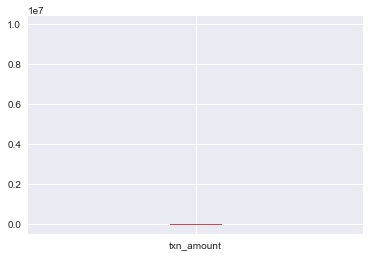

In [102]:
acc_transacitons['txn_amount'].plot(kind='box')

In [103]:
acc_transacitons.describe()

,account_no,from_to_account_no,txn_amount,txn_hour,to_outside
count,2.012569e+06,2.012569e+06,2.012569e+06,2.012569e+06,2.012569e+06
mean,3.450028e+09,1.999751e+09,5.045252e+03,1.400241e+01,5.795364e-01
std,1.489065e+04,1.703334e+09,3.200802e+04,4.855766e+00,4.936335e-01
min,3.450000e+09,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00
25%,3.450016e+09,0.000000e+00,2.000000e+02,1.100000e+01,0.000000e+00
50%,3.450030e+09,3.450166e+09,5.500000e+02,1.400000e+01,1.000000e+00
75%,3.450041e+09,3.450698e+09,2.500000e+03,1.800000e+01,1.000000e+00
max,3.450050e+09,3.451196e+09,9.866600e+06,2.300000e+01,1.000000e+00


In [104]:
acc_transacitons.describe(include=['O'])

,txn_dt,txn_type
count,2012569,2012569
unique,261,2
top,2016-08-31,CR
freq,11662,1062231


In [105]:
# Add to outside feature
acc_transacitons['to_outside'] = (acc_transacitons['from_to_account_no'] > 0).astype('int')

In [106]:
pd.crosstab(acc_transacitons['to_outside'], acc_transacitons['txn_type'])

txn_type,CR,DR
to_outside,,
0,324571,521641
1,737660,428697


## Create feature from 1st table

In [107]:
# Create deposit feature
acc_outside = acc_transacitons[['account_no', 'to_outside']].groupby('account_no').agg(['sum', 'count'])

acc_outside_df = pd.DataFrame({
    'outside_count': acc_outside['to_outside']['sum'],
    'all_count': acc_outside['to_outside']['count'],
    'outside_ratio': (acc_outside['to_outside']['sum']) / (acc_outside['to_outside']['count'])
})

acc_outside_df = acc_outside_df.reset_index()

In [108]:
acc_outside_df.head()

,account_no,all_count,outside_count,outside_ratio
0,3450000010,1392,619,0.444684
1,3450000011,949,469,0.494204
2,3450000012,85,36,0.423529
3,3450000014,2986,2638,0.883456
4,3450000015,1,1,1.000000


In [109]:
acctran_dr = acc_transacitons[acc_transacitons['txn_type'] == 'DR']
acctran_cr = acc_transacitons[acc_transacitons['txn_type'] == 'CR']

In [110]:
# Create CR Features
dep_cr = acctran_cr[['account_no', 'txn_amount']].groupby('account_no').agg(['mean', 'count', 'sum'])

acc_cr = pd.DataFrame({
    'cr_mean': dep_cr['txn_amount']['mean'],
    'cr_count': dep_cr['txn_amount']['count'],
    'cr_sum': dep_cr['txn_amount']['sum']
})

acc_cr = acc_cr.reset_index()

acc_cr.head()

,account_no,cr_count,cr_mean,cr_sum
0,3450000010,1267,93.764799,118800
1,3450000011,403,1403.473945,565600
2,3450000012,26,1088.461538,28300
3,3450000014,2866,240.823447,690200
4,3450000015,1,750.000000,750


In [111]:
# Create DR Features
dep_dr = acctran_dr[['account_no', 'txn_amount']].groupby('account_no').agg(['mean', 'count', 'sum'])

acc_dr = pd.DataFrame({
    'dr_mean': dep_dr['txn_amount']['mean'],
    'dr_count': dep_dr['txn_amount']['count'],
    'dr_sum': dep_dr['txn_amount']['sum']
})

acc_dr = acc_dr.reset_index()

acc_dr.head()

,account_no,dr_count,dr_mean,dr_sum
0,3450000010,125,1003.200000,125400
1,3450000011,546,957.234432,522650
2,3450000012,59,290.677966,17150
3,3450000014,120,5327.500000,639300
4,3450000016,5,150.000000,750


In [112]:
# Create Outside DR Feature
dep_outside_dr = acc_transacitons[ (acc_transacitons['to_outside'] == 1) & (acc_transacitons['txn_type'] == 'DR') ]
dep_outside_dr = dep_outside_dr[['account_no', 'txn_amount']].groupby('account_no').agg(['count', 'sum'])

acc_dr_outside = pd.DataFrame({
    'dr_outside_sum': dep_outside_dr['txn_amount']['sum'],
    'dr_outside_count': dep_outside_dr['txn_amount']['count']
})

acc_dr_outside = acc_dr_outside.reset_index()

In [113]:
# Create Outside DR Feature
dep_outside_cr = acc_transacitons[ (acc_transacitons['to_outside'] == 1) & (acc_transacitons['txn_type'] == 'CR') ]
dep_outside_cr = dep_outside_cr[['account_no', 'txn_amount']].groupby('account_no').agg(['count', 'sum'])

acc_cr_outside = pd.DataFrame({
    'cr_outside_sum': dep_outside_cr['txn_amount']['sum'],
    'cr_outside_count': dep_outside_cr['txn_amount']['count']
})

acc_cr_outside = acc_cr_outside.reset_index()

In [114]:
# Merge all deposits features
acc_deposits = acc_outside_df.merge(acc_cr, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_dr, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_dr_outside, how='outer', on='account_no')
acc_deposits = acc_deposits.merge(acc_cr_outside, how='outer', on='account_no')
acc_deposits = acc_deposits.fillna(0)
acc_deposits.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum
0,3450000010,1392,619,0.444684,1267.0,93.764799,118800.0,125.0,1003.200000,125400.0,68.0,89000.0,551.0,59750.0
1,3450000011,949,469,0.494204,403.0,1403.473945,565600.0,546.0,957.234432,522650.0,180.0,135400.0,289.0,417100.0
2,3450000012,85,36,0.423529,26.0,1088.461538,28300.0,59.0,290.677966,17150.0,25.0,5750.0,11.0,5750.0
3,3450000014,2986,2638,0.883456,2866.0,240.823447,690200.0,120.0,5327.500000,639300.0,19.0,20500.0,2619.0,633550.0
4,3450000015,1,1,1.000000,1.0,750.000000,750.0,0.0,0.000000,0.0,0.0,0.0,1.0,750.0


## Extract credit card data

In [115]:
cardacc_transactions = card_transactions.merge(acc_card, how='left', on='card_no')

In [116]:
cardacc_transactions.head()

,card_no,txn_date,txn_hour,txn_amount,mer_cat_code,mer_id,account_no
0,1234000000009154,2016-12-07 00:00:00.0,22,1550,4511,0,3450000392
1,1234000000017165,2016-12-07 00:00:00.0,22,250,6011,0,3450040668
2,1234000000000768,2016-12-07 00:00:00.0,22,250,8398,0,3450015325
3,1234000000018716,2016-12-07 00:00:00.0,22,50,5735,0,3450032598
4,1234000000010162,2016-12-07 00:00:00.0,22,200,4121,0,3450021131


In [126]:
# Create Outside DR Feature
cardacc_amount = cardacc_transactions[['account_no', 'txn_amount']].groupby('account_no').agg(['count', 'sum', 'mean'])

cardacc_amount_df = pd.DataFrame({
    'credit_sum': cardacc_amount['txn_amount']['sum'],
    'credit_count': cardacc_amount['txn_amount']['count'],
    'credit_mean': cardacc_amount['txn_amount']['mean']
})

cardacc_amount_df = cardacc_amount_df.reset_index()
cardacc_amount_df.head()

,account_no,credit_count,credit_mean,credit_sum
0,3450000010,87,1500.000000,130500
1,3450000016,16,10725.000000,171600
2,3450000017,22,3090.909091,68000
3,3450000018,46,218.478261,10050
4,3450000024,167,854.491018,142700


In [127]:
acc_fulldata = acc_deposits.merge(cardacc_amount_df, how='left', on='account_no')
acc_fulldata.fillna(0, inplace=True)
acc_fulldata.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum,credit_count,credit_mean,credit_sum
0,3450000010,1392,619,0.444684,1267.0,93.764799,118800.0,125.0,1003.200000,125400.0,68.0,89000.0,551.0,59750.0,87.0,1500.0,130500.0
1,3450000011,949,469,0.494204,403.0,1403.473945,565600.0,546.0,957.234432,522650.0,180.0,135400.0,289.0,417100.0,0.0,0.0,0.0
2,3450000012,85,36,0.423529,26.0,1088.461538,28300.0,59.0,290.677966,17150.0,25.0,5750.0,11.0,5750.0,0.0,0.0,0.0
3,3450000014,2986,2638,0.883456,2866.0,240.823447,690200.0,120.0,5327.500000,639300.0,19.0,20500.0,2619.0,633550.0,0.0,0.0,0.0
4,3450000015,1,1,1.000000,1.0,750.000000,750.0,0.0,0.000000,0.0,0.0,0.0,1.0,750.0,0.0,0.0,0.0


## Combine test & train data

In [128]:
traindata_full = traindata.merge(acc_fulldata, how='left', on='account_no')
testdata_full = testdata.merge(acc_fulldata, how='left', on='account_no')

In [129]:
traindata_full.head()

,account_no,is_merchant,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum,credit_count,credit_mean,credit_sum
0,3450023212,1,1490,1265,0.848993,1270.0,1423.346457,1807650.0,220.0,6675.681818,1468650.0,117.0,1449250.0,1148.0,1048800.0,0.0,0.000000,0.0
1,3450001274,0,17,1,0.058824,5.0,1400.000000,7000.0,12.0,504.166667,6050.0,1.0,1000.0,0.0,0.0,0.0,0.000000,0.0
2,3450033744,0,4,2,0.500000,1.0,400.000000,400.0,3.0,283.333333,850.0,1.0,400.0,1.0,400.0,67.0,723.880597,48500.0
3,3450030139,0,2,0,0.000000,0.0,0.000000,0.0,2.0,2750.000000,5500.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,3450016925,0,1,0,0.000000,1.0,58000.000000,58000.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,34.0,317.647059,10800.0


In [130]:
testdata_full.head()

,account_no,all_count,outside_count,outside_ratio,cr_count,cr_mean,cr_sum,dr_count,dr_mean,dr_sum,dr_outside_count,dr_outside_sum,cr_outside_count,cr_outside_sum,credit_count,credit_mean,credit_sum
0,3450004069,1,0,0.000000,0.0,0.000000,0.0,1.0,15000.000000,15000.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,3450049874,76,24,0.315789,23.0,1250.000000,28750.0,53.0,468.867925,24850.0,14.0,3650.0,10.0,3750.0,66.0,2974.242424,196300.0
2,3450011367,20,4,0.200000,6.0,3458.333333,20750.0,14.0,1310.714286,18350.0,3.0,7350.0,1.0,1200.0,130.0,1032.307692,134200.0
3,3450002087,26,4,0.153846,11.0,2859.090909,31450.0,15.0,3416.666667,51250.0,1.0,1600.0,3.0,14600.0,0.0,0.000000,0.0
4,3450035141,130,69,0.530769,67.0,2292.537313,153600.0,63.0,3572.222222,225050.0,34.0,94900.0,35.0,68600.0,98.0,1035.714286,101500.0


## Predict

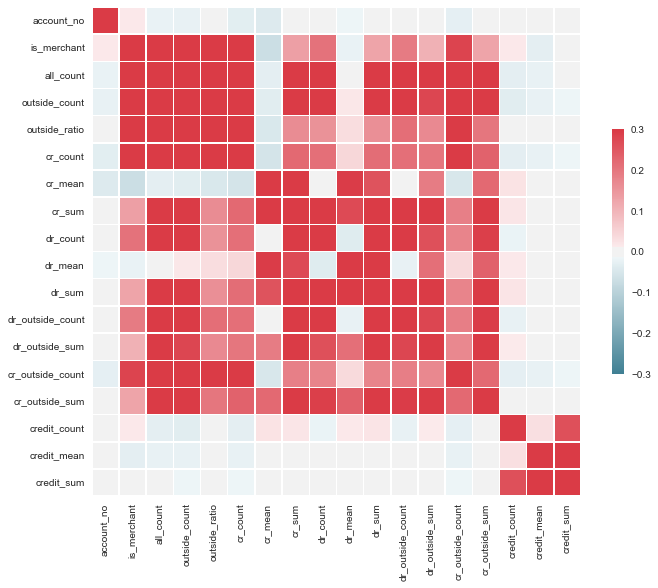

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = traindata_full.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [65]:
# Predict
from sklearn.model_selection import cross_val_score, train_test_split

In [132]:
# Settings
use_columns = [
    'outside_ratio',
    'cr_count',
    'cr_mean',
    'cr_sum',
    'dr_count',
    'dr_mean',
    'dr_sum',
    'dr_outside_sum',
    'dr_outside_count',
    'cr_outside_sum',
    'cr_outside_count',
    'credit_count',
    'credit_sum'
]

target_column = 'is_merchant'

# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

# from sklearn.ensemble import AdaBoostClassifier
# model = AdaBoostClassifier(n_estimators=100, learning_rate=0.2)

# from sklearn import svm
# model = svm.SVC()

# model = XGBClassifier(max_depth=5)

testsze = 0.3

In [133]:
# Test Model
x_train, x_test, y_train, y_test = train_test_split(
    traindata_full[use_columns],
    traindata_full[target_column], test_size = testsze)

estimator = model.fit(x_train, y_train)

cross_val_score(estimator, x_test, y_test, cv=10)

array([ 0.82142857,  0.79285714,  0.85714286,  0.83571429,  0.84642857,
        0.82142857,  0.825     ,  0.81362007,  0.82437276,  0.86379928])

In [134]:
# Find Parameters

# from sklearn.model_selection import GridSearchCV
# parameters = {'learning_rate':[0.01,0.05,0.1,0.2,0.3,0.5,0.7,1], 'n_estimators':[10,30,50,70,100,200,500,1000]}
# model = AdaBoostClassifier()
# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train)
# print(clf.best_params_)
# print(clf.cv_results_)

In [135]:
# Find features important

# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(estimator, prefit=True)

# estimator.feature_importances_

In [136]:
# Save File
import numpy as np
predict_y = estimator.predict(testdata_full[use_columns])

np.savetxt('2.txt', predict_y, fmt="%d")